In [24]:
from mmdnn.conversion.examples.mxnet.imagenet_test import Batch

In [ ]:
y_pred = [[0.5000368],[0.5000373],
[0.5000471],
[0.50004],
[0.50005],
[0.50005245],
[0.50005275],
[0.5000449],
[0.5000544],
[0.50005734],
[0.5000564],
[0.5000378],
[0.5000452],
[0.5000574],
[0.50004077],
[0.50004494]]

y_true = [[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[1.],[1.],[1.],[1.],[1.],[1.],[1.],[1.]]

In [1]:
def get_model():
    from tensorflow.keras.models import Sequential
    from keras import initializers
    from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 1), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 1), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [7]:
import numpy as np
import os
def fullpath(path, files):
    return  [(lambda x: path + x)(x) for x in files]
val_dir = "../chest_xray/chest_xray/val"
filesPneumo = fullpath(val_dir+'/PNEUMONIA/',os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
del filesPneumo[0]
labelsPneumo = np.zeros(len(filesPneumo))
filesNormal = fullpath(val_dir+'/NORMAL/',os.listdir(os.path.join(val_dir, 'NORMAL')))
del filesNormal[0]
labelsNormal = np.ones(len(filesNormal))
fileData = filesPneumo + filesNormal
fileLabels = np.concatenate((labelsPneumo,labelsNormal),axis=0).astype(np.float32)

In [2]:

model = get_model()


Using TensorFlow backend.


In [8]:
from PIL import Image
from mxnet import autograd, np , npx
npx.set_np()
x = Image.open(filesNormal[0])
x = x.resize([320,320])
x = np.array(x).reshape(320*320*1)

In [18]:
x2 = Image.open(filesNormal[1])
x2 = x2.resize([320,320])
x2 = np.array(x2).reshape(320*320*1)

In [22]:
x = x.reshape(1,320,320,1)
#x = x.reshape(-1,1)

In [9]:
type(last_layer)

tensorflow.python.keras.layers.core.Dense

In [3]:
last_layer.get_config()

{'name': 'conv2d_4',
 'trainable': True,
 'dtype': 'float32',
 'filters': 128,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0.0, 'stddev': 0.01, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [30]:
import mxnet as mx
from mxnet.gluon import nn, Trainer, loss
from mxnet import optimizer
from mxnet import autograd, np, npx
def convert_keras_to_mxnet(model):
    npx.set_np()
    def layer_conversion(layer):
        t = str(type(layer)).split(".")
        layer_type = t[-1].replace('\'>',"")
        config = layer.get_config()
        if layer_type == "Dense":
            return nn.Dense(units=config['units'], activation=config['activation'], use_bias=config['use_bias'], dtype=np.float32)
        if layer_type == "Conv2D":
            return nn.Conv2D(channels=config['filters'], kernel_size=config['kernel_size'],use_bias=config['use_bias'],activation=config['activation'], weight_initializer=mx.init.Normal(0.01), bias_initializer=mx.init.Zero())
        if layer_type == "MaxPooling2D":
            return nn.MaxPool2D(pool_size=config['pool_size'])
        if layer_type == "BatchNormalization":
            return nn.BatchNorm(momentum=config['momentum'], epsilon=config['epsilon'])
        if layer_type=="Dropout":
            return nn.Dropout(rate=config['rate'])
        if layer_type=="Flatten":
            return nn.Flatten()
        return None
    mxModel = nn.Sequential()
    for layer in model.layers:
        new_layer = layer_conversion(layer)
        mxModel.add(new_layer)
    return mxModel

new_model = convert_keras_to_mxnet(model)

In [21]:
len(model.layers)

19

In [44]:
new_model.collect_params()

sequential15_ (
  Parameter conv48_weight (shape=(32, -1, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv48_bias (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm48_gamma (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm48_beta (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm48_running_mean (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm48_running_var (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter conv49_weight (shape=(32, -1, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv49_bias (shape=(32,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm49_gamma (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm49_beta (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm49_running_mean (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter batchnorm49_running_var (shape=(-1,), dtype=<class 'numpy.float32'>)
  Parameter conv50_weight (shape=(64, -1, 3, 3), dtype=<class 

In [185]:
new_model.initialize(force_reinit=True)

In [56]:
from mxnet import image
x = image.imread(fileData[0])
x = image.imresize(x,320,320)

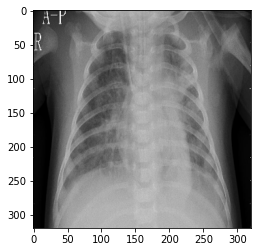

In [57]:
import matplotlib.pyplot as plt
plt.imshow(x.asnumpy())
plt.show()

In [61]:
def preprocess(img):
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img.astype(np.float32)
xnew = preprocess(x)

In [63]:
y = new_model.forward(xnew)

In [166]:
y_true = np.array(1.).reshape(-1,1)

In [186]:
params = new_model[-1].collect_params()

In [187]:
dense_W = params.get("weight").data()
dense_B = params.get("bias").data()

In [88]:
dense_W.attach_grad()
dense_B.attach_grad()

In [109]:
BCE = loss.SigmoidBinaryCrossEntropyLoss()

In [195]:
dense_W

array([[-5.3594191e-02,  2.4885694e-02,  4.1046590e-02,  1.2773038e-02,
         4.4739310e-02,  4.9214326e-03, -1.0362288e-02,  9.2152454e-04,
        -3.7563562e-02, -2.4234492e-02, -2.5094792e-02, -2.0193813e-02,
        -5.8633447e-02, -4.2688148e-04, -8.7563694e-04,  3.8776457e-02,
        -3.7902709e-02,  5.4915860e-02, -3.0298915e-02,  1.6803533e-02,
         2.4539167e-02,  1.0772064e-02,  2.3520324e-02,  5.2548371e-02,
        -4.1785010e-05, -6.0221031e-03, -3.2059811e-02, -9.0072230e-03,
         5.3284019e-02, -7.9773525e-03, -5.4764397e-02, -4.8249640e-02,
        -2.9963300e-02,  5.4387428e-02, -1.5744325e-02,  6.6944189e-02,
         3.8786203e-02, -5.9105542e-02, -2.9689701e-02,  3.5965621e-02,
        -3.4808446e-02, -6.7469463e-02, -6.9879524e-02,  3.4000821e-02,
        -3.8446486e-02,  4.1463710e-02,  1.3977950e-02, -3.3333816e-02,
         5.5463389e-02, -1.1011329e-02,  3.7264854e-02, -4.0666319e-02,
        -5.3454820e-02,  4.8515398e-02,  1.9987613e-02,  4.42813

In [189]:
trainer=mx.gluon.Trainer(new_model.collect_params(),'adam', {'learning_rate': 0.001})

In [193]:
with autograd.record():
    y_ =  new_model.forward(xnew)
    lossValue = BCE(y_, y_true)
print( str(y_) + "; Loss: " + str(lossValue))

[[0.00720028]]; Loss: [0.6895536]


In [194]:
lossValue.backward()
trainer.step(xnew.shape[0])

In [101]:
dense_W.grad

array([[0.0000000e+00, 0.0000000e+00, 1.2440111e-05, 1.4292451e-05,
        0.0000000e+00, 0.0000000e+00, 1.5807294e-05, 0.0000000e+00,
        2.5595906e-05, 0.0000000e+00, 9.4625193e-06, 3.8364746e-05,
        0.0000000e+00, 0.0000000e+00, 4.0965995e-05, 0.0000000e+00,
        7.9775291e-06, 5.1399940e-05, 6.1903415e-06, 0.0000000e+00,
        1.8286584e-05, 0.0000000e+00, 1.8294151e-05, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.5887748e-05, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3382403e-05,
        1.8189672e-05, 0.0000000e+00, 0.0000000e+00, 1.7643251e-05,
        1.9167379e-05, 1.9677280e-05, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.7517015e-05, 6.5818549e-06, 0.0000000e+00, 2.7552353e-05,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 7.6379147e-06, 3.8345270e

In [102]:
dense_B.grad


array([6.539645e-07])